# Credit Card Fraud Detection ML Pipeline

This notebook demonstrates a complete machine learning pipeline for fraud detection using transactional data and custom-built model. The pipeline includes data loading, preprocessing, feature engineering, model training, and evaluation

## Project Overview
- **Goal**: Build a model that accurately identifies fraudulent credit card transactions
- **Dataset**: Kaggle Fraud Detection Dataset with transaction details, merchant information, and user data
- **Approach**: Gradient boosting 
classification with categorical and numerical feature processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.data.loader import DataLoader
from src.data.preprocessor import DataPreprocessor

from src.model.model import FraudDetectionModel


## Data Loading

Loading the processed training and testing datasets. The data contains credit card transactions with various features including:
- Transaction details 
- Merchant information
- Customer demographics
- Geographic data

In [2]:
d = DataLoader(os.path.join(project_root, "data/processed"))

d.load_data("train.csv", "test.csv")
train_df = d.train_data
test_df = d.test_data

In [3]:
train_df.shape, test_df.shape

((296000, 22), (111144, 22))

In [4]:
train_df['trans_date'], train_df['trans_time'] = zip(*train_df['trans_date_trans_time'].apply(lambda x: x.strip().split(' ')))
train_df.drop('trans_date_trans_time', axis=1, inplace=True)

test_df['trans_date'], test_df['trans_time'] = zip(*test_df['trans_date_trans_time'].apply(lambda x: x.strip().split(' ')))
test_df.drop('trans_date_trans_time', axis=1, inplace=True)

## Feature Type Detection

The following functions help us automatically detect different column types in our dataset:
- Numerical features: For amounts, coordinates, population, etc.
- Categorical features: For merchant names, categories, etc.
- Date/time features: For transaction timing

In [5]:
def detect_date_columns(df : pd.DataFrame, numerical: list[str]) -> list[str]:
    date_columns = []
    for col in df.columns:
        if col in numerical:
            continue
        try:
            temp_series = pd.to_datetime(df[col], errors="coerce")
            if temp_series.notna().any():
                date_columns.append(col)
        except Exception:
            pass
    return date_columns

def get_column_types(df : pd.DataFrame) -> tuple:
    # exclude target column 
    numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    numerical_columns.remove("is_fraud")

    # exclude target column
    date_columns = detect_date_columns(df.copy(), numerical_columns)
    date_columns.remove("is_fraud")

    categorical_columns = [
        col
        for col in df.select_dtypes(include=["object"]).columns
        if col not in date_columns
    ]

    target_col = "is_fraud"

    return (
        numerical_columns,
        categorical_columns,
        date_columns,
        target_col
    )

In [6]:
train_numerical_columns, train_categorical_columns, train_date_columns, train_target_col = get_column_types(train_df)
test_numerical_columns, test_categorical_columns, test_date_columns, test_target_col = get_column_types(test_df)

/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_9611/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_9611/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_9611/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys3sg

In [7]:
test_numerical_columns, test_categorical_columns, test_date_columns, test_target_col

(['cc_num',
  'amt',
  'zip',
  'lat',
  'long',
  'city_pop',
  'unix_time',
  'merch_lat',
  'merch_long'],
 ['merchant',
  'category',
  'first',
  'last',
  'gender',
  'street',
  'city',
  'state',
  'job',
  'trans_num'],
 ['dob', 'trans_date', 'trans_time'],
 'is_fraud')

In [8]:
train_numerical_columns == test_numerical_columns, \
    train_categorical_columns == test_categorical_columns, \
    train_date_columns == test_date_columns, \
    train_target_col == test_target_col

(True, True, True, True)

<h5>
The feature sets in the training and test datasets are identical
</h5>

In [9]:
from sklearn.model_selection import train_test_split

train = train_df.copy()
val, test = train_test_split(
    test_df,
    test_size=0.8,
    stratify=test_df[train_target_col],
    random_state=42,
)

In [10]:
train.shape, val.shape, test.shape

((296000, 23), (22228, 23), (88916, 23))

## Feature Preprocessing

Now we'll apply our preprocessor to transform raw data into ML-ready features:
- Encoding categorical variables
- Scaling numerical features
- Extracting time-based features from dates

In [11]:
p = DataPreprocessor(train_categorical_columns, train_numerical_columns, 'is_fraud', train_date_columns)

p = p.fit(train)

/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/data/preprocessor.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


In [12]:
val

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,trans_time
21690,3559160581764413,"fraud_Casper, Hand and Zulauf",grocery_pos,96.73,Allen,Bell,M,70147 Amanda Fields,Saint Bonaventure,NY,...,1453,Toxicologist,1974-02-15,0e86754789102044ac3a9291497e8d7b,1372755903,43.070331,-77.817824,0,2020-07-02,09:05:03
109604,213193596103206,fraud_Kuhic LLC,shopping_net,88.10,James,Hunt,M,7369 Gabriel Tunnel,Pointe Aux Pins,MI,...,95,Electrical engineer,1994-02-09,a80e97a6f53c51792c9f523d081c4f6a,1380088448,45.328339,-83.752631,0,2020-09-25,05:54:08
101413,4292743669224718067,fraud_Eichmann-Kilback,home,34.86,Michael,Williams,M,35822 Clayton Street Apt. 679,Great Mills,MD,...,5927,Art therapist,1973-06-09,ccc7b1a59318807bfd3d06904f735d90,1373824923,37.509716,-76.241005,0,2020-07-14,18:02:03
13127,4658490815480264,fraud_Metz-Boehm,shopping_pos,2.25,Tara,Richards,F,4879 Cristina Station,Keisterville,PA,...,184,Systems developer,1945-11-04,7cba6e1f3cf4b2c7baa0cdd85c5d7ce6,1383364819,40.774376,-78.817336,0,2020-11-02,04:00:19
15370,6011860238257910,"fraud_Greenholt, Jacobi and Gleason",gas_transport,51.51,Lisa,Mendez,F,44259 Beth Station Suite 215,Lahoma,OK,...,1078,"Programme researcher, broadcasting/film/video",1952-07-06,c4560223b88b007003a76ce471cdae23,1373607740,35.816957,-97.976276,0,2020-07-12,05:42:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108302,4128730454058057622,"fraud_Conroy, Balistreri and Gorczany",health_fitness,27.61,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,...,43,"Engineer, production",1949-10-04,251057432c545b06e2ca23276495cc16,1375543198,31.454164,-94.966471,0,2020-08-03,15:19:58
5060,343819048608995,fraud_Bode-Rempel,kids_pets,33.56,Shelby,Cannon,F,1535 Ryan Burgs Suite 919,Des Moines,IA,...,222785,Wellsite geologist,1956-01-24,66af34ef8cbc92863391213534f3f01e,1373327706,41.625498,-92.814804,0,2020-07-08,23:55:06
40812,3559679414981506,fraud_Hills-Witting,shopping_net,27.72,Olivia,Stephenson,F,292 Cassidy Oval,Lowville,NY,...,8830,Theme park manager,1991-03-29,6a8cd6e5f23639a69ad2938e69e9a0cf,1384558310,43.733475,-74.642072,0,2020-11-15,23:31:50
75958,213163860545705,"fraud_Lang, Towne and Schuppe",kids_pets,49.26,Mark,Tyler,M,82201 Bradley Radial Suite 703,Avera,GA,...,741,Claims inspector/assessor,1986-04-28,0edf370d1276f38cc65a085b88a2b3be,1373994465,32.623455,-83.179778,0,2020-07-16,17:07:45


In [13]:
X, y = p.transform(train)
X_val, y_val = p.transform(val)
X_test, y_test = p.transform(test)
X.shape, y.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/data/preprocessor.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/data/preprocessor.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/data/preprocessor.py:92: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


((296000, 18), (296000,), (22228, 18), (22228,), (88916, 18), (88916,))

## Model Training

We'll use a gradient boosting model for fraud detection. This model works well with tabular data and can capture complex patterns in transactional data

In [14]:
fd = FraudDetectionModel(
    X.shape[1],
)

y = np.array(y).astype(np.float64)

fd.train(X, y)
acc_val = fd.evaluate(X_val, y_val)


/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/model/model.py:123: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
2025-04-20 00:01:09,761 - model - INFO - Training step completed. Average loss: 0.6940
2025-04-20 00:01:09,862 - model - INFO - Evaluation completed. Accuracy: 0.9962, Correct: 22143, Total: 22228


In [15]:
acc_test = fd.evaluate(X_test, y_test)

2025-04-20 00:01:10,262 - model - INFO - Evaluation completed. Accuracy: 0.9962, Correct: 88575, Total: 88916


In [16]:
acc_val['accuracy'], acc_test['accuracy']

(0.9961759942414972, 0.9961649196994916)

## Visualizations

/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/model/model.py:123: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


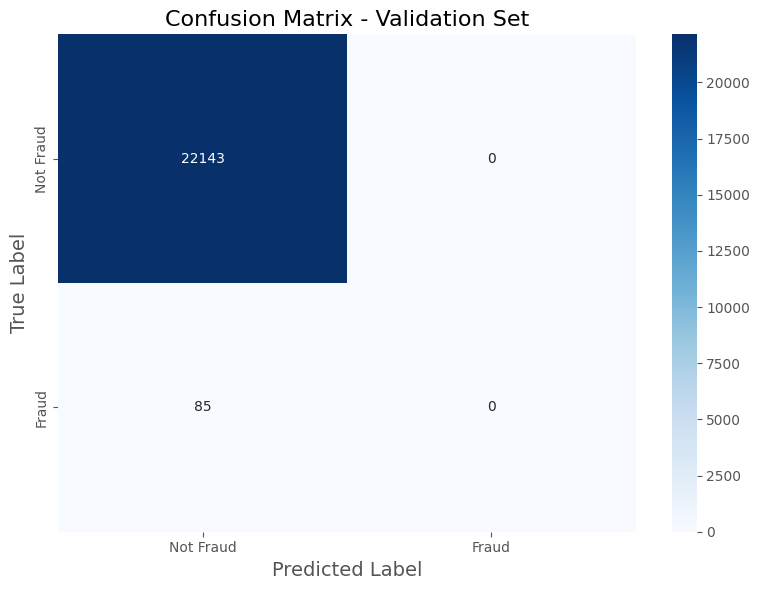

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22143
           1       0.00      0.00      0.00        85

    accuracy                           1.00     22228
   macro avg       0.50      0.50      0.50     22228
weighted avg       0.99      1.00      0.99     22228



/Users/oleh.kravchenko/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oleh.kravchenko/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/oleh.kravchenko/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

y_val_pred = []
for i in range(len(X_val)):
    pred_prob = fd.predict(X_val[i])
    pred_class = round(pred_prob)
    y_val_pred.append(pred_class)

cm = confusion_matrix(y_val, y_val_pred);

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud']);
plt.title('Confusion Matrix - Validation Set', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show();

print(classification_report(y_val, y_val_pred));

<h5>
The graph shows that the model correctly identifies 99% of transactions, with only 85 transactions falsely classified as non-fraud
</h5>

/Users/oleh.kravchenko/fraud-detection-ML-pipeline/src/model/model.py:123: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


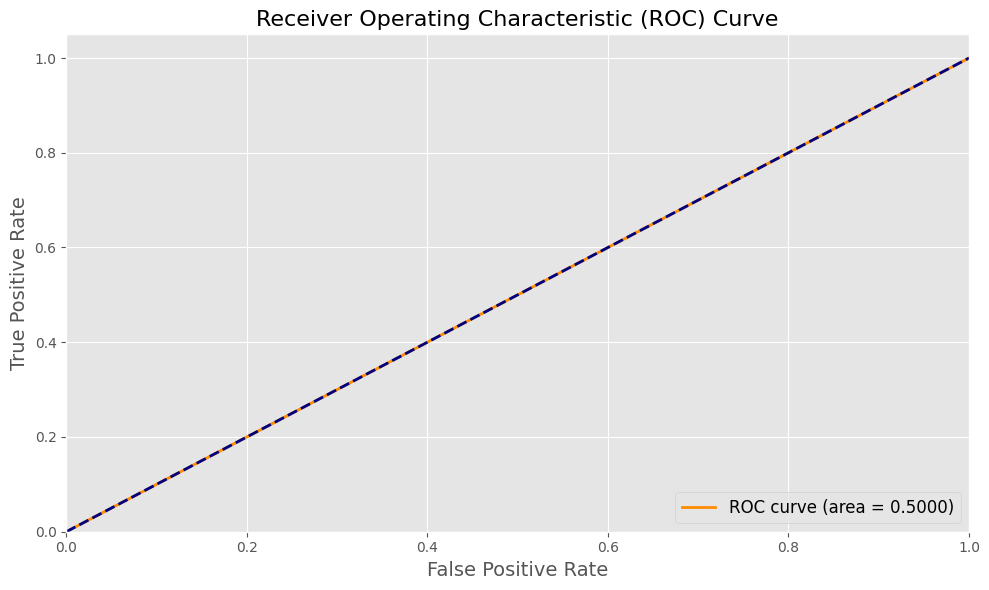

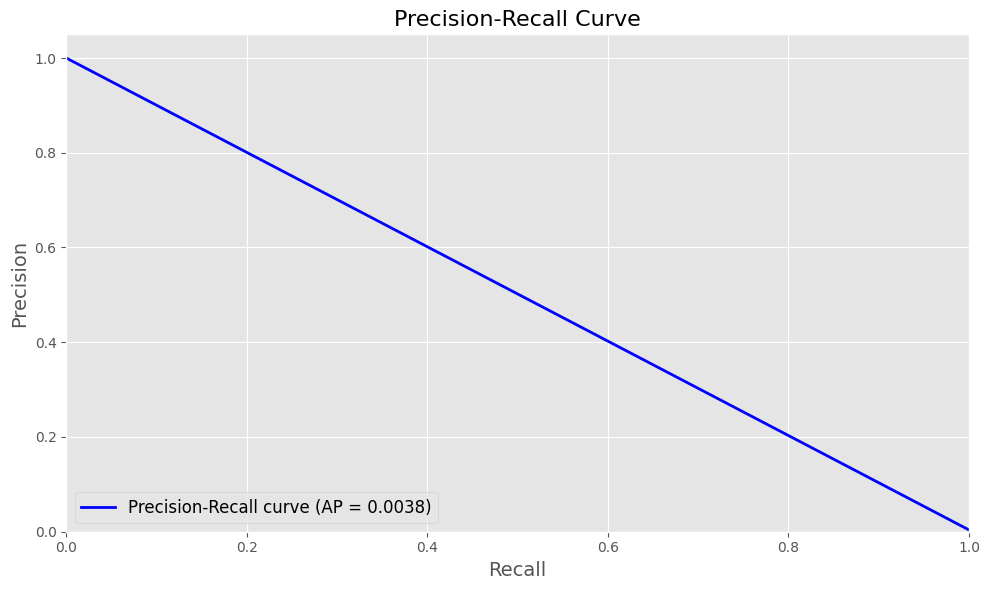

In [25]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

y_val_probs = []
for i in range(len(X_val)):
    pred_prob = fd.predict(X_val[i])
    y_val_probs.append(pred_prob)

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
avg_precision = average_precision_score(y_val, y_val_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.tight_layout()
plt.show()

## Results and Conclusion

The model achieves high accuracy on both validation and test sets, showing it generalizes well to unseen data.


### Future Improvements
- Try different models like neural networks or ensemble methods
- Add more feature engineering based on domain knowledge
